<a href="https://colab.research.google.com/github/ViktorTurchenko/SkimLitProject/blob/main/SkimLit_Final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SkimLit project: Classify scientific paper abstracts into groups of text to simplify reading

## Part 1: Import data and dependecies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Confirm access to a GPU
tf.__version__

'2.9.2'

In [ ]:
# Get data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!dir pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 11.73 MiB/s, done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PubMed_20k datset
!dir pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
# Prepare path to file
data_dir  = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
print(data_dir)

dir: cannot access 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/': No such file or directory
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/


In [6]:
# Unzip the data
import zipfile
with zipfile.ZipFile("pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip","r") as zip_ref:
    zip_ref.extractall("pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/")

## Part 2: Preprocess the data

### Import file and read the lines

In [7]:
# Create a function to read the lines from a document
def get_lines(filename):
    """
    Read filename and returns the lines of text as a list.

    Args:
        filename: a string containing the target filepath
    """
    with open(filename, "r") as f:
        return f.readlines()

In [8]:
# Function that extracts data from text
def preprocess_text_with_line_numbers(filename):
    """
    Returns a list of dictionaries of abstract line data containing .
    """
    input_lines = get_lines(filename=filename)
    abstract_lines = ""
    abstract_samples = []
    # loop through each line in the target file
    for line in input_lines:
        if line.startswith('###'):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstact_line_split = abstract_lines.splitlines()
            for abstract_line_number, abstract_line in enumerate(abstact_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstact_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line 
    
    return abstract_samples

In [9]:
# Get data from file and preprocess it

train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distrbution of labels
test_df.target.value_counts()

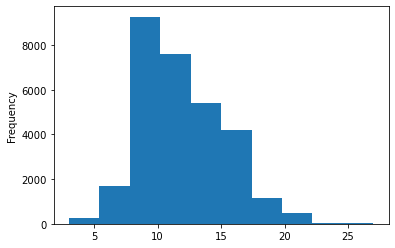

In [ ]:
# Distribution of lines in abstract
test_df.total_lines.plot.hist();

### Split the sentences into words and chars

In [11]:
# Get text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)
# The number sshould match with the previous numbers

(180040, 30212, 30135)

In [16]:
# Split sequence level data into character-level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [15]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))


### One-hot encode: target labels, line numbers, total line number

In [13]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

In [12]:
# The depth of # line is 15, #total lines is 20 
# Create one-hot encoded tensors
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

# Create one-hot encoded tensors
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Encode target labels in ints

In [14]:
# Extract labels and ecode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

In [17]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [18]:
# Find what character length covers 95%
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

## Part 3: Create custom embeddings

### Import pretrained Universal Sentence Encoder from tensorflow hub

In [25]:
# Import the embedding layer from tf_hub
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        dtype=tf.string,
                                        name="universal_sentence_encoder")

### Create Custom Token Embeddings

In [19]:
# How many words in out vocab (says in paper)
max_tokens = 68000
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                        output_sequence_length=55)# 95% of sentences in the datasset have less than 55 words or tokens
# Fit text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [20]:
# How many words in train vocab
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
# Create token embedding later
text_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                                output_dim=128,
                                mask_zero=True,
                                name="token_embedding")

### Create Custom Character Embeddings

In [21]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase+string.digits + string.punctuation
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    name="char_vectorizer")


In [22]:
# Adapt it to our training characters
char_vectorizer.adapt(train_chars)

In [23]:
# Get char vocab 
char_vocab = char_vectorizer.get_vocabulary()
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              name="char_embed")

## Part 4: Prepare datasets for training

In [30]:
# Create training and validation datasetss with all four kinds of inputs
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Valid dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Test dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                                test_total_lines_one_hot,
                                                                test_sentences,
                                                                test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


## Part 5: Default Model 

In [26]:
# Default model

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype = tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line number inputs model
line_number_inputs = layers.Input(shape=(15,), dtype = tf.float32, name="line_number_input")
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype = tf.float32, name="total_lines_input")
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

# 5. Concatenate 1 and 2
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                  char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6 Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="chat_token_positional_embedding")([line_number_model.output,
                                                                                total_line_model.output,
                                                                                 z])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name = "output_layer")(tribrid_embeddings)

# 8. Put all together
model_default = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input], outputs = output_layer)

In [27]:
model_default.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_input[0][0]']      

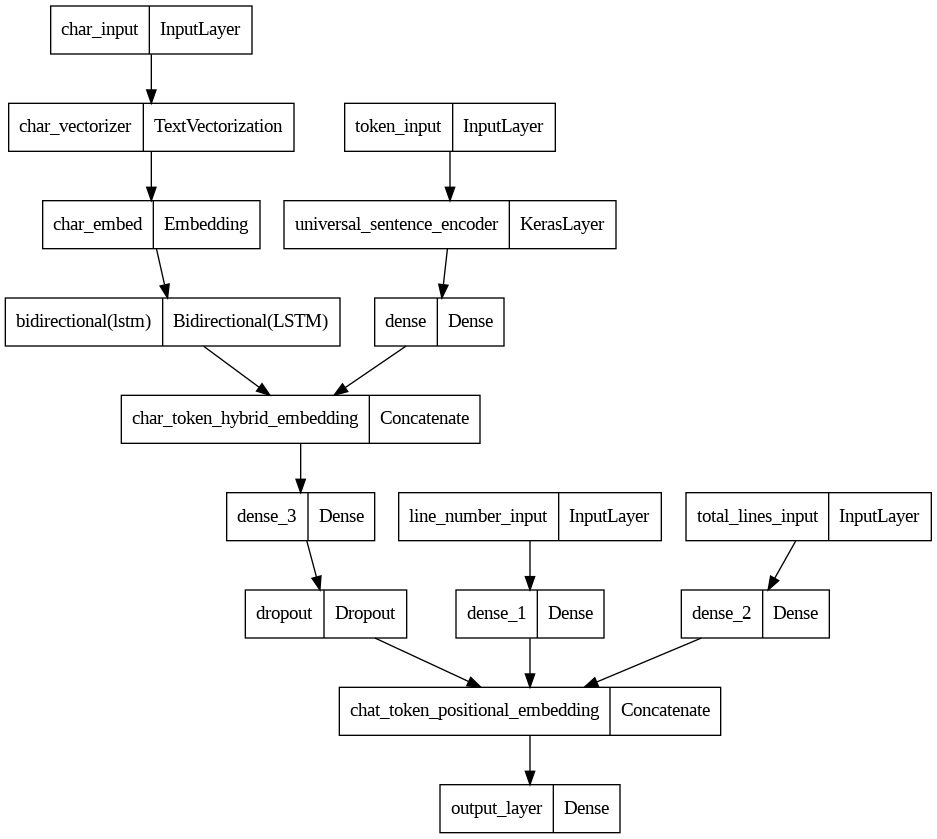

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model_default)

In [29]:
# Compiling the model
model_default.compile(loss=tf.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [32]:
# Set checkpoint path
checkpoint_path = "/content/drive/MyDrive/SkimLit/model_default/"

# Create a ModelCheckpoint callback that saves your model's weight
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         verbose=1)

In [33]:
history_default=model_default.fit(train_char_token_pos_dataset,
                    steps_per_epoch=len(train_char_token_pos_dataset),
                    epochs=15,
                    validation_data=val_char_token_pos_dataset,
                    validation_steps=len(val_char_token_pos_dataset),
                    callbacks=[checkpoint_callback])

Epoch 1/15
5627/5627 [==============================] - ETA: 0s - loss: 0.9554 - accuracy: 0.8212
Epoch 1: val_accuracy improved from -inf to 0.84721, saving model to /content/drive/MyDrive/SkimLit/model_default/
5627/5627 [==============================] - 303s 51ms/step - loss: 0.9554 - accuracy: 0.8212 - val_loss: 0.9096 - val_accuracy: 0.8472
Epoch 2/15
5627/5627 [==============================] - ETA: 0s - loss: 0.9098 - accuracy: 0.8532
Epoch 2: val_accuracy improved from 0.84721 to 0.85440, saving model to /content/drive/MyDrive/SkimLit/model_default/
5627/5627 [==============================] - 285s 51ms/step - loss: 0.9098 - accuracy: 0.8532 - val_loss: 0.9005 - val_accuracy: 0.8544
Epoch 3/15
5627/5627 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.8616
Epoch 3: val_accuracy improved from 0.85440 to 0.85459, saving model to /content/drive/MyDrive/SkimLit/model_default/
5627/5627 [==============================] - 285s 51ms/step - loss: 0.8971 - accura

In [34]:
# Make predictions
model_default_pred_probs = model_default.predict(test_char_token_pos_dataset, verbose = 1)
model_default_pred_probs, model_default_pred_probs.shape
# Convert pred probs to classes
model_default_preds = tf.argmax(model_default_pred_probs, axis = 1)

942/942 [==============================] - 23s 22ms/step


In [35]:
from helper_functions import calculate_results
model_default_results = calculate_results(test_labels_encoded, model_default_preds)
model_default_results

{'accuracy': 84.53957192633152,
 'precision': 0.8450784124200732,
 'recall': 0.8453957192633151,
 'f1': 0.8426924392674481}

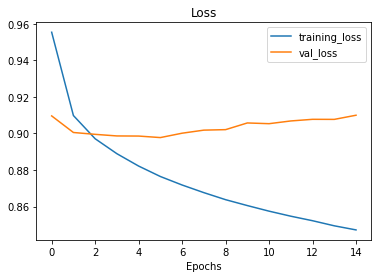

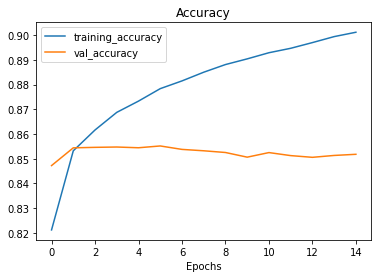

In [36]:
from helper_functions import plot_loss_curves
plot_loss_curves(history_default)

In [39]:
# Save history and model 
import pickle
with open('/content/drive/MyDrive/SkimLit/model_default/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history_default.history, file_pi)

model_default.save("/content/drive/MyDrive/SkimLit/model_default/")

## Part 6: Custom embeddings model

In [45]:
# Custom embeddings model

# 1. Setup token inputs/model
text_inputs = layers.Input(shape=(1,), dtype=tf.string, name="text_input")
text_vectors = text_vectorizer(text_inputs)
text_embeddings = text_embed(text_vectors)
text_bi_lstm = layers.Bidirectional(layers.LSTM(24))(text_embeddings)
text_model = tf.keras.Model(text_inputs, text_bi_lstm)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Line number inputs model
line_number_inputs = layers.Input(shape=(15,), dtype = tf.float32, name="line_number_input")
x = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype = tf.float32, name="total_lines_input")
y = layers.Dense(32, activation='relu')(total_lines_inputs)
total_line_model = tf.keras.Model(total_lines_inputs, y)

# 5. Concatenate 1 and 2
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([text_model.output,
                                                                  char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="chat_token_positional_embedding")([line_number_model.output,
                                                                                total_line_model.output,
                                                                                 z])
final_dense = layers.Dense(128, activation="relu")(tribrid_embeddings)
final_dense = layers.Dropout(0.2)(final_dense)

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name = "output_layer")(final_dense)

# 8. Put all together
model_c_embed = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 text_model.input,
                                 char_model.input], outputs = output_layer, name="model_2")

In [46]:
model_c_embed.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 55)          0           ['text_input[0][0]']             
 ization)                                                                                         
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']       

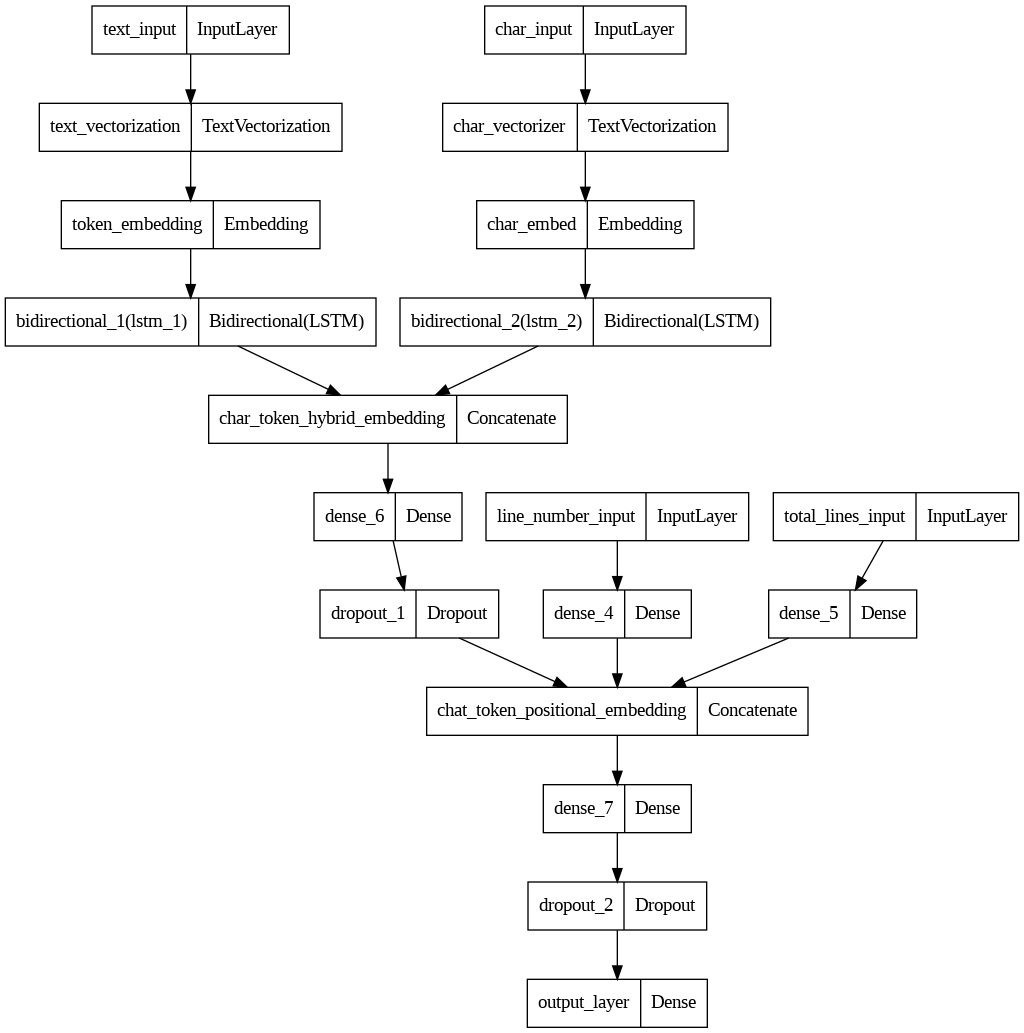

In [47]:
from keras.utils.vis_utils import plot_model
plot_model(model_c_embed)

In [48]:
# Compiling the model
model_c_embed.compile(loss=tf.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [49]:
# Set checkpoint path
checkpoint_path = "/content/drive/MyDrive/SkimLit/model_c_embed/"

# Create a ModelCheckpoint callback that saves your model's weight
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         verbose=1)

In [50]:
history_c_embed=model_c_embed.fit(train_char_token_pos_dataset,
                    steps_per_epoch=len(train_char_token_pos_dataset),
                    epochs=15,
                    validation_data=val_char_token_pos_dataset,
                    validation_steps=len(val_char_token_pos_dataset),
                    callbacks=[checkpoint_callback])

Epoch 1/15
5627/5627 [==============================] - ETA: 0s - loss: 0.8910 - accuracy: 0.8578
Epoch 1: val_accuracy improved from -inf to 0.88392, saving model to /content/drive/MyDrive/SkimLit/model_c_embed/
5627/5627 [==============================] - 323s 55ms/step - loss: 0.8910 - accuracy: 0.8578 - val_loss: 0.8411 - val_accuracy: 0.8839
Epoch 2/15
5627/5627 [==============================] - ETA: 0s - loss: 0.8185 - accuracy: 0.9068
Epoch 2: val_accuracy did not improve from 0.88392
5627/5627 [==============================] - 304s 54ms/step - loss: 0.8185 - accuracy: 0.9068 - val_loss: 0.8474 - val_accuracy: 0.8791
Epoch 3/15
5627/5627 [==============================] - ETA: 0s - loss: 0.7781 - accuracy: 0.9365
Epoch 3: val_accuracy did not improve from 0.88392
5627/5627 [==============================] - 305s 54ms/step - loss: 0.7781 - accuracy: 0.9365 - val_loss: 0.8605 - val_accuracy: 0.8730
Epoch 4/15
5626/5627 [============================>.] - ETA: 0s - loss: 0.7484 - 

In [51]:
# Make predictions
model_c_embed_pred_probs = model_c_embed.predict(test_char_token_pos_dataset, verbose = 1)
model_c_embed_pred_probs, model_c_embed_pred_probs.shape
# Convert pred probs to classes
model_c_embed_preds = tf.argmax(model_c_embed_pred_probs, axis = 1)

942/942 [==============================] - 20s 16ms/step


In [52]:
from helper_functions import calculate_results
model_c_embed_results = calculate_results(test_labels_encoded, model_c_embed_preds)
model_c_embed_results

{'accuracy': 84.9377799900448,
 'precision': 0.848440975638071,
 'recall': 0.849377799900448,
 'f1': 0.8484264588080678}

In [ ]:
from helper_functions import plot_loss_curves
plot_loss_curves(history_c_embed)

In [53]:
# Save history and model 
import pickle
with open('/content/drive/MyDrive/SkimLit/model_default/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history_c_embed.history, file_pi)


model_c_embed.save("/content/drive/MyDrive/SkimLit/model_c_embed/")

IsADirectoryError: ignored